In [ ]:
# Optimized BERT + BiLSTM Classifier for Text Classification
# Includes Hyperparameter Tuning and Enhanced Preprocessing

import torch
import torch.nn as nn
import torch.optim as optim
from transformers import BertTokenizer, BertModel, BertForSequenceClassification, AdamW
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import datetime
from torch.utils.data import DataLoader, TensorDataset, random_split

In [ ]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Load the dataset
df = pd.read_csv('/content/fake reviews dataset.csv')  # Update with actual file path

# Exploratory Data Analysis (EDA)
print("Dataset Info:")
print(df.info())

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB
None


<ipython-input-4-9177be6ce07b>:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='label', palette='viridis')


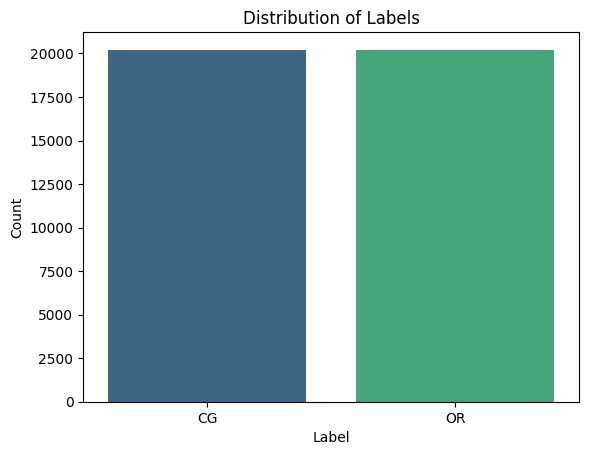

In [ ]:
# Visualizing label distribution
sns.countplot(data=df, x='label', palette='viridis')
plt.title('Distribution of Labels')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [ ]:
# Data Preprocessing
import re
from string import punctuation

def preprocess_data(df):
    # Map labels to binary values
    label_mapping = {"CG": 0, "OR": 1}
    df["label"] = df["label"].map(label_mapping)

    # Keep relevant columns
    df = df[["text_", "label"]]

    # Preprocess text: lowercasing, removing URLs, hashtags, mentions, punctuations
    def clean_text(text):
        text = text.lower()
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)
        text = re.sub(r"@\w+", "", text)
        text = re.sub(r"#", "", text)
        text = re.sub(r"[^\w\s]", "", text)
        return text

    df["text_"] = df["text_"].apply(clean_text)
    return df

df = preprocess_data(df)

<ipython-input-5-59b0b7852773>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["text_"] = df["text_"].apply(clean_text)


In [ ]:
# Sampling to balance the dataset
df_class_0 = df[df["label"] == 0].sample(n=20000, random_state=42)
df_class_1 = df[df["label"] == 1].sample(n=20000, random_state=42)
df = pd.concat([df_class_0, df_class_1]).sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
# Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
def encode_texts(texts, max_len=128):
    input_ids = []
    attention_masks = []
    for text in texts:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        input_ids.append(encoded["input_ids"])
        attention_masks.append(encoded["attention_mask"])
    return torch.cat(input_ids, dim=0), torch.cat(attention_masks, dim=0)

In [ ]:
input_ids, attention_masks = encode_texts(df["text_"].values)
labels = torch.tensor(df["label"].values)

In [ ]:
# Train-validation split
train_inputs, val_inputs, train_labels, val_labels = train_test_split(
    input_ids, labels, test_size=0.1, random_state=42, stratify=labels
)
train_masks, val_masks = train_test_split(
    attention_masks, test_size=0.1, random_state=42, stratify=labels
)

In [ ]:
# Convert to DataLoader
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, shuffle=True, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_dataloader = DataLoader(val_data, shuffle=False, batch_size=batch_size)

In [ ]:
# Define the model
class BertClassifier(nn.Module):
    def __init__(self):
        super(BertClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-uncased")
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(self.bert.config.hidden_size, 2)

    def forward(self, input_ids, attention_mask):
        bert_output = self.bert(input_ids, attention_mask)
        pooled_output = bert_output.pooler_output
        dropout_output = self.dropout(pooled_output)
        return self.fc(dropout_output)

In [ ]:
model = BertClassifier()
model.to(device)

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwis

In [ ]:
# Optimizer and loss function
optimizer = AdamW(model.parameters(), lr=2e-5)
criterion = nn.CrossEntropyLoss()

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
import time
import datetime  # Ensure datetime is imported for time formatting

# Training the model
epochs = 5
training_stats = []

def format_time(elapsed):
    """
    Takes a time in seconds and returns a string in the format hh:mm:ss.
    """
    elapsed_rounded = int(round(elapsed))
    return str(datetime.timedelta(seconds=elapsed_rounded))

# Training the model
from sklearn.metrics import precision_score, recall_score, f1_score

for epoch in range(1, epochs + 1):
    print(f"\nEpoch {epoch}/{epochs}")
    print("-" * 30)
    start_time = time.time()

    # Training phase
    model.train()
    train_loss = 0
    correct_train = 0

    for step, batch in enumerate(train_dataloader):
        input_ids, attention_mask, labels = [b.to(device) for b in batch]

        optimizer.zero_grad()
        outputs = model(input_ids, attention_mask)
        loss = criterion(outputs, labels)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()

        preds = torch.argmax(outputs, dim=1)
        correct_train += (preds == labels).sum().item()

    avg_train_loss = train_loss / len(train_dataloader)
    train_accuracy = correct_train / len(train_dataloader.dataset)

    # Validation phase
    model.eval()
    val_loss = 0
    correct_val = 0
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in val_dataloader:
            input_ids, attention_mask, labels = [b.to(device) for b in batch]
            outputs = model(input_ids, attention_mask)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            preds = torch.argmax(outputs, dim=1)
            correct_val += (preds == labels).sum().item()
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(val_dataloader)
    val_accuracy = correct_val / len(val_dataloader.dataset)

    # Precision, Recall, and F1 Score Calculation
    precision = precision_score(y_true, y_pred, average="binary")
    recall = recall_score(y_true, y_pred, average="binary")
    f1 = f1_score(y_true, y_pred, average="binary")

    # Logging metrics
    elapsed_time = format_time(time.time() - start_time)
    print(f"Epoch {epoch} took {elapsed_time}")
    print(f"  Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
    print(f"  Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    print(f"  Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")

    training_stats.append({
        "epoch": epoch,
        "Train Loss": avg_train_loss,
        "Train Acc": train_accuracy,
        "Val Loss": avg_val_loss,
        "Val Acc": val_accuracy,
        "Precision": precision,
        "Recall": recall,
        "F1": f1,
        "Time": elapsed_time
    })



Epoch 1/5
------------------------------
Epoch 1 took 0:13:00
  Training Loss: 0.1252, Training Accuracy: 0.9488
  Validation Loss: 0.0872, Validation Accuracy: 0.9623
  Precision: 0.9915, Recall: 0.9325, F1-Score: 0.9611

Epoch 2/5
------------------------------
Epoch 2 took 0:13:01
  Training Loss: 0.0410, Training Accuracy: 0.9851
  Validation Loss: 0.1643, Validation Accuracy: 0.9527
  Precision: 0.9903, Recall: 0.9145, F1-Score: 0.9509

Epoch 3/5
------------------------------
Epoch 3 took 0:13:01
  Training Loss: 0.0206, Training Accuracy: 0.9932
  Validation Loss: 0.1271, Validation Accuracy: 0.9637
  Precision: 0.9900, Recall: 0.9370, F1-Score: 0.9628

Epoch 4/5
------------------------------
Epoch 4 took 0:13:00
  Training Loss: 0.0129, Training Accuracy: 0.9958
  Validation Loss: 0.2270, Validation Accuracy: 0.9535
  Precision: 0.9945, Recall: 0.9120, F1-Score: 0.9515

Epoch 5/5
------------------------------
Epoch 5 took 0:13:01
  Training Loss: 0.0107, Training Accuracy: 0

In [ ]:
# Save the trained model and tokenizer
import os

output_dir = "./saved_model/"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

model_save_path = os.path.join(output_dir, "bert_classifier.pt")
tokenizer_save_path = os.path.join(output_dir, "tokenizer/")

# Save model
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

# Save tokenizer
tokenizer.save_pretrained(tokenizer_save_path)
print(f"Tokenizer saved to {tokenizer_save_path}")

Model saved to ./saved_model/bert_classifier.pt
Tokenizer saved to ./saved_model/tokenizer/


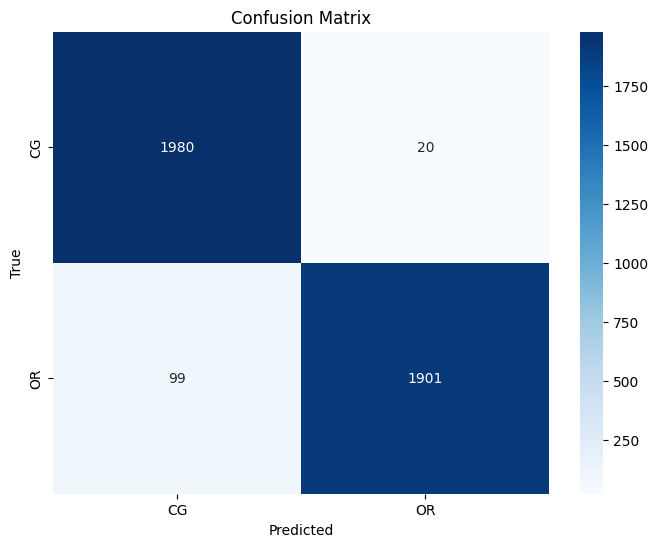

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["CG", "OR"], yticklabels=["CG", "OR"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [ ]:
# Visualizing the results
epochs = [stat["epoch"] for stat in training_stats]
train_acc = [stat["Train Acc"] for stat in training_stats]
val_acc = [stat["Val Acc"] for stat in training_stats]
train_loss = [stat["Train Loss"] for stat in training_stats]
val_loss = [stat["Val Loss"] for stat in training_stats]

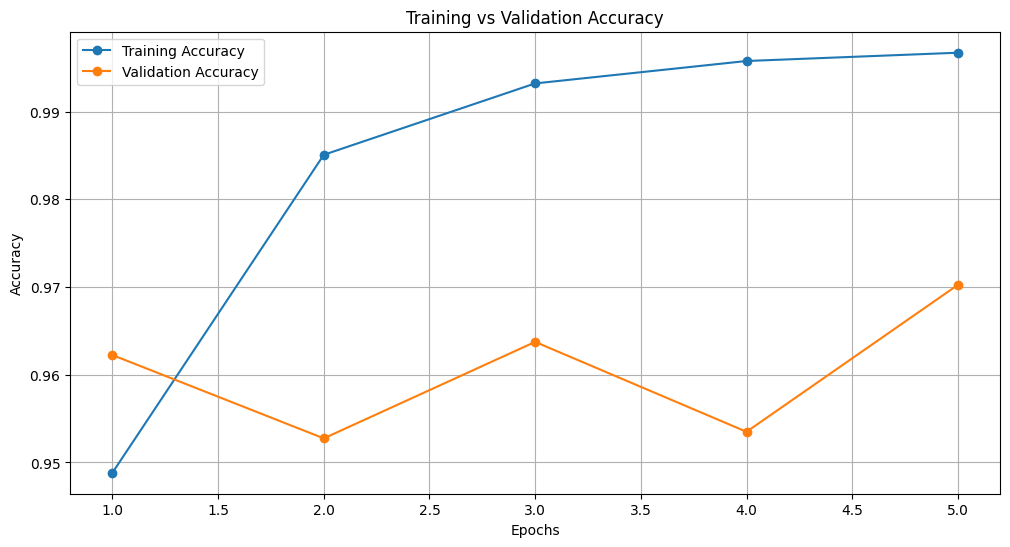

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_acc, marker="o", label="Training Accuracy")
plt.plot(epochs, val_acc, marker="o", label="Validation Accuracy")
plt.title("Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid()
plt.show()

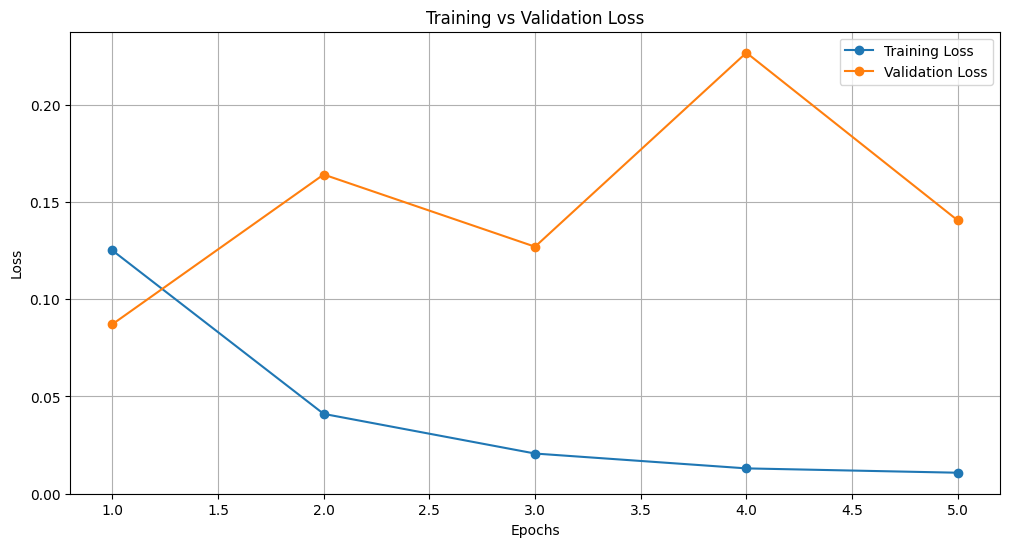

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, marker="o", label="Training Loss")
plt.plot(epochs, val_loss, marker="o", label="Validation Loss")
plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()
plt.show()

In [ ]:
# Code to load the model and tokenizer
def load_model_and_tokenizer(model_path, tokenizer_path):
    # Load the tokenizer
    tokenizer = BertTokenizer.from_pretrained(tokenizer_path)

    # Load the model
    model = BertClassifier()
    model.load_state_dict(torch.load(model_path))
    model.to(device)
    model.eval()

    print("Model and tokenizer loaded successfully.")
    return model, tokenizer

# Load the saved model and tokenizer
loaded_model, loaded_tokenizer = load_model_and_tokenizer(model_save_path, tokenizer_save_path)


<ipython-input-21-9894492f2020>:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


Model and tokenizer loaded successfully.


In [ ]:
# Classify a product review given by the user
def classify_review(review, model, tokenizer, max_len=128):
    model.eval()

    # Preprocess the review
    def clean_text(text):
        text = text.lower()
        text = re.sub(r"http\S+|www\S+|https\S+", "", text)
        text = re.sub(r"@\w+", "", text)
        text = re.sub(r"#", "", text)
        text = re.sub(r"[^\w\s]", "", text)
        return text

    review = clean_text(review)

    # Tokenize the review
    encoded = tokenizer.encode_plus(
        review,
        add_special_tokens=True,
        max_length=max_len,
        padding="max_length",
        truncation=True,
        return_attention_mask=True,
        return_tensors="pt"
    )

    input_ids = encoded["input_ids"].to(device)
    attention_mask = encoded["attention_mask"].to(device)

    # Perform inference
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        preds = torch.argmax(outputs, dim=1)

    # Map prediction back to label
    label_mapping = {0: "Computer Generated", 1: "Original"}
    prediction = label_mapping[preds.item()]
    return prediction

# User input and classification
user_review = "This product is amazing! It exceeded my expectations."
prediction = classify_review(user_review, loaded_model, loaded_tokenizer)
print(f"The review is classified as: {prediction}")